In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
from linearmodels.panel import PanelOLS, RandomEffects
from sklearn.inspection import PartialDependenceDisplay
import os
import warnings
from scipy import stats
from statsmodels.regression.quantile_regression import QuantReg


In [ ]:
import pandas as pd
import numpy as np

# File path
file_path = r"C:\Users\jiaju\Desktop\Final_data.xlsx"

# Load Sheet1
data = pd.read_excel(file_path, sheet_name="Sheet1")

In [3]:
# 将 Date 列转换为日期格式
def parse_quarter(date_str):
    quarter, year = date_str.split()
    year = int(year)
    if quarter == 'Q1':
        return f'{year}-01-01'
    elif quarter == 'Q2':
        return f'{year}-04-01'
    elif quarter == 'Q3':
        return f'{year}-07-01'
    elif quarter == 'Q4':
        return f'{year}-10-01'
    return None

data['Date'] = pd.to_datetime(data['Date'].apply(parse_quarter), errors='coerce')
print("Date 列类型：", data['Date'].dtype)
print("Date 列前五行：\n", data['Date'].head())

Date 列类型： datetime64[ns]
Date 列前五行：
 0   2016-01-01
1   2016-04-01
2   2016-07-01
3   2016-10-01
4   2017-01-01
Name: Date, dtype: datetime64[ns]


In [ ]:
 
# drop rows with the same Date & Company, keep the first
df = data.drop_duplicates(subset=['Date', 'COMPANY'], keep='first')

In [ ]:

# 2) Winsorize specified columns at the 1st and 99th percentile
to_winsor = [
    "Current ratio",
    "Interest coverage ratio",
    "ROA",
    "ROE",
    "Leverage ratio",
    "Market to book ratio",
    "Risk free rate",
    "CDS spread"
]

for col in to_winsor:
    q_low  = df[col].quantile(0.01)
    q_high = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=q_low, upper=q_high)

# 3) Log-transform Total assets and Market value
for col in ["Total assets", "Market value"]:
    # if there’s a chance of zero or negative values, add a small constant:
    df["log_" + col.replace(" ", "_").lower()] = np.log(df[col].clip(lower=1e-6))

In [9]:
# 选择特征和目标变量
exclude_cols = ['CDS spread', 'ID', 'Date', 'Quarter', 'Year', 'COMPANY', 'Country',
                'ISIN CODE', 'TICKER SYMBOL', 'ICB industry name', 'ICB sector name']
features = df.drop(columns=exclude_cols)
target = df['CDS spread']

# 移除国家虚拟变量和行业虚拟变量
country_dummies = [col for col in features.columns if col in ['AUSTRIA', 'BELGIUM', 'CZECH_REPUBLIC', 'DENMARK',
                                                             'FINLAND', 'FRANCE', 'GERMANY', 'GREECE', 'ITALY',
                                                             'NETHERLANDS', 'NORWAY', 'PORTUGAL', 'SPAIN', 'SWEDEN',
                                                             'SWITZERLAND', 'UNITED_KINGDOM', 'UNITED_STATES']]
industry_dummies = [col for col in features.columns if col in ['Basic_Materials', 'Consumer_Discretionary',
                                                               'Consumer_Staples', 'Energy', 'Financials',
                                                               'Health_Care', 'Industrials', 'Real_Estate',
                                                               'Technology', 'Telecommunications', 'Utilities']]
features = features.drop(columns=country_dummies + industry_dummies)
print(f"调试信息：国家虚拟变量: {country_dummies}")
print(f"调试信息：行业虚拟变量: {industry_dummies}")
print(f"调试信息：保留的特征: {features.columns.tolist()}")

调试信息：国家虚拟变量: []
调试信息：行业虚拟变量: ['Basic_Materials', 'Consumer_Discretionary', 'Consumer_Staples', 'Energy', 'Financials', 'Health_Care', 'Industrials', 'Real_Estate', 'Technology', 'Telecommunications', 'Utilities']
调试信息：保留的特征: ['Community Score', 'CSR Strategy Score', 'Emissions Score', 'Environment Pillar Score', 'Environmental Innovation Score', 'ESG Combined Score', 'ESG Controversies Score', 'ESG Score', 'Governance Pillar Score', 'Human Rights Score', 'Management Score', 'Product Responsibility Score', 'Resource Use Score', 'Shareholders Score', 'Social Pillar Score', 'TRDIR Controversies Score', 'TRDIR Diversity Score', 'TRDIR Inclusion Score', 'TRDIR People Development Score', 'Workforce Score', 'Book value per share', 'Common shares outstanding', 'Current ratio', 'Interest coverage ratio', 'Historical volatility 5 years', 'Market value', 'ROA', 'ROE', 'Total assets', 'Leverage ratio', 'Market to book ratio', 'Risk free rate', 'Austria', 'Belgium', 'Czech_republic', 'Denmark', 'Fi

In [12]:
# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
feature_names = features.columns

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

# 2. 描述性统计
print("\n### 描述性统计 ###")
print("基本统计信息：")
print(df.describe())

训练集大小: (14400, 51), 测试集大小: (3600, 51)

### 描述性统计 ###
基本统计信息：
                ID                 Date          Year    CDS spread  \
count  18000.00000                18000  18000.000000  18000.000000   
mean    9669.30800  2020-05-16 14:00:00   2020.000000    115.574130   
min        1.00000  2016-01-01 00:00:00   2016.000000     -5.484420   
25%     4788.75000  2018-03-09 12:00:00   2018.000000     33.039990   
50%     9576.50000  2020-05-16 12:00:00   2020.000000     60.964995   
75%    14400.25000  2022-07-24 00:00:00   2022.000000    111.340000   
max    19584.00000  2024-10-01 00:00:00   2024.000000   1190.770000   
std     5622.18008                  NaN      2.582061    181.537007   

       Community Score  CSR Strategy Score  Emissions Score  \
count     18000.000000        18000.000000     18000.000000   
mean         75.108838           64.090168        67.863378   
min           0.810000            0.000000         0.000000   
25%          59.850000           52.420000     

In [18]:
# 相关性分析
correlation = df[feature_names.tolist() + ['CDS spread']].corr()
print("与 CDS spread 的相关性（前10个）：")
print(correlation['CDS spread'].sort_values(ascending=False).head(10))


与 CDS spread 的相关性（前10个）：
CDS spread                       1.000000
Historical volatility 5 years    0.044877
TRDIR Inclusion Score            0.040770
United States                    0.037625
Risk free rate                   0.032578
Shareholders Score               0.029964
France                           0.020067
Market to book ratio             0.018652
Czech_republic                   0.014534
Current ratio                    0.013186
Name: CDS spread, dtype: float64


In [13]:
# 离群值检测
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3)
print("离群值数量：", len(outliers[0]))

# ESG 评分的非线性转换（对数转换）
esg_log = np.log1p(data['ESG Score'])
print("ESG Score 对数转换后描述：")
print(esg_log.describe())

# 3. 面板回归分析
print("\n### 面板回归分析 ###")
data_panel = df.set_index(['COMPANY', 'Date'])

离群值数量： 19038
ESG Score 对数转换后描述：
count    18252.000000
mean         4.165636
std          0.305267
min          0.647103
25%          4.095469
50%          4.222445
75%          4.362716
max          4.615121
Name: ESG Score, dtype: float64

### 面板回归分析 ###


In [21]:
# 固定效应模型
panel_model_fe = PanelOLS(data_panel['CDS spread'], data_panel[feature_names], entity_effects=True, time_effects=True, drop_absorbed=True)
panel_results_fe = panel_model_fe.fit()
print("固定效应面板回归结果：")
print(panel_results_fe.summary)

# 随机效应模型
panel_model_re = RandomEffects(data_panel['CDS spread'], data_panel[feature_names])
panel_results_re = panel_model_re.fit()
print("随机效应面板回归结果：")
print(panel_results_re.summary)

# 分位数回归
quantiles = [0.1, 0.5, 0.9]
for q in quantiles:
    model = QuantReg(data['CDS spread'], data[feature_names])
    res = model.fit(q=q)
    print(f"分位数 {q} 回归结果：")
    print(res.summary())


C:\Users\jiaju\AppData\Local\Temp\ipykernel_31844\4245505332.py:3: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

Austria, Belgium, Denmark, Finland, France, Germany, Greece, Italy, Netherlands, Norway, Portugal, Spain, Sweden, Switzerland, United Kingdom, United States

  panel_results_fe = panel_model_fe.fit()


固定效应面板回归结果：
                          PanelOLS Estimation Summary                           
Dep. Variable:             CDS spread   R-squared:                        0.0399
Estimator:                   PanelOLS   R-squared (Between):             -7738.9
No. Observations:               18000   R-squared (Within):               0.0212
Date:                Sun, Jun 15 2025   R-squared (Overall):             -5805.5
Time:                        22:06:37   Log-likelihood                -1.337e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      21.282
Entities:                         500   P-value                           0.0000
Avg Obs:                       36.000   Distribution:                F(34,17431)
Min Obs:                       36.000                                           
Max Obs:                       36.000   F-statistic (robust):             21.282
                

KeyError: "['log_total_assets', 'log_market_value'] not in index"


### LASSO 回归分析 ###


C:\Users\jiaju\.anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.903e+04, tolerance: 3.782e+04
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jiaju\.anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.214e+06, tolerance: 3.782e+04
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jiaju\.anaconda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.273e+06

最佳 alpha: 0.08406652885618317
LASSO 回归 R² (测试集): 0.12044199260841693
LASSO 系数：
Social Pillar Score               26.468411
Environment Pillar Score          24.744435
Czech_republic                    20.977785
Shareholders Score                15.549927
TRDIR Inclusion Score             14.849912
Common shares outstanding         10.793430
ESG Combined Score                 7.044868
Market value                       6.932868
Market to book ratio               6.748992
Austria                            6.109562
Book value per share               5.882853
Management Score                   5.882110
Human Rights Score                 5.411384
TRDIR Diversity Score              4.595244
France                             2.044023
Historical volatility 5 years      1.837271
Interest coverage ratio            1.489927
Sweden                             0.734093
TRDIR People Development Score     0.416934
Norway                             0.328180
Denmark                            0.1094

C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\3685831355.py:18: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\3685831355.py:18: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\3685831355.py:18: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\3685831355.py:18: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\3685831355.py:18: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2

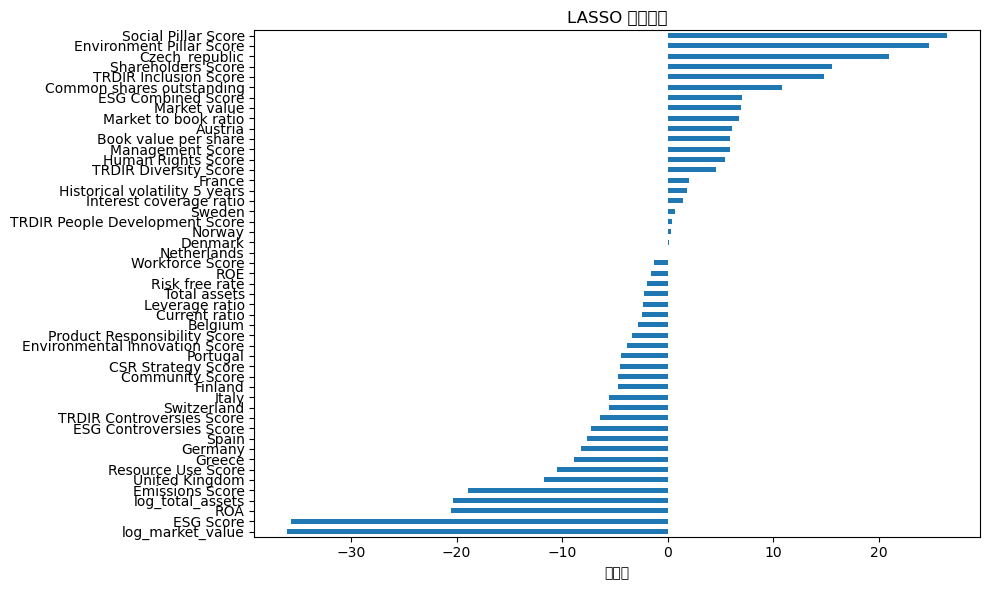

<Figure size 640x480 with 0 Axes>

In [16]:
# 4. LASSO 回归（优化 alpha）
print("\n### LASSO 回归分析 ###")
lasso_cv = LassoCV(alphas=np.logspace(-6, 1, 200), cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)
print(f"最佳 alpha: {lasso_cv.alpha_}")
lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso.fit(X_train, y_train)
print("LASSO 回归 R² (测试集):", lasso.score(X_test, y_test))
lasso_coef = pd.Series(lasso.coef_, index=feature_names)
print("LASSO 系数：")
print(lasso_coef[lasso_coef != 0].sort_values(ascending=False))

# LASSO 系数图
plt.figure(figsize=(10, 6))
lasso_coef[lasso_coef != 0].sort_values().plot(kind='barh')
plt.title('LASSO 回归系数')
plt.xlabel('系数值')
plt.tight_layout()
plt.show()
plt.savefig("my_plot.png")   

In [21]:
# 5. 机器学习模型
# 随机森林（超参数调优）
print("\n### 随机森林模型 ###")
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), rf_param_grid, cv=5, scoring='r2')
rf_grid.fit(X_train, y_train)
print("最佳参数:", rf_grid.best_params_)
rf = rf_grid.best_estimator_
rf_r2 = rf.score(X_test, y_test)
print(f"随机森林 R² (测试集): {rf_r2:.4f}")



### 随机森林模型 ###
最佳参数: {'max_depth': 20, 'n_estimators': 200}
随机森林 R² (测试集): 0.8864


C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\957440254.py:7: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\957440254.py:7: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\957440254.py:7: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\957440254.py:7: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\957440254.py:7: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\957440254.py:7: UserWarning: Glyph 26862 (\N{CJK UNIFIE

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jiaju\\vis\\rf_feature_importance.png'

C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: 

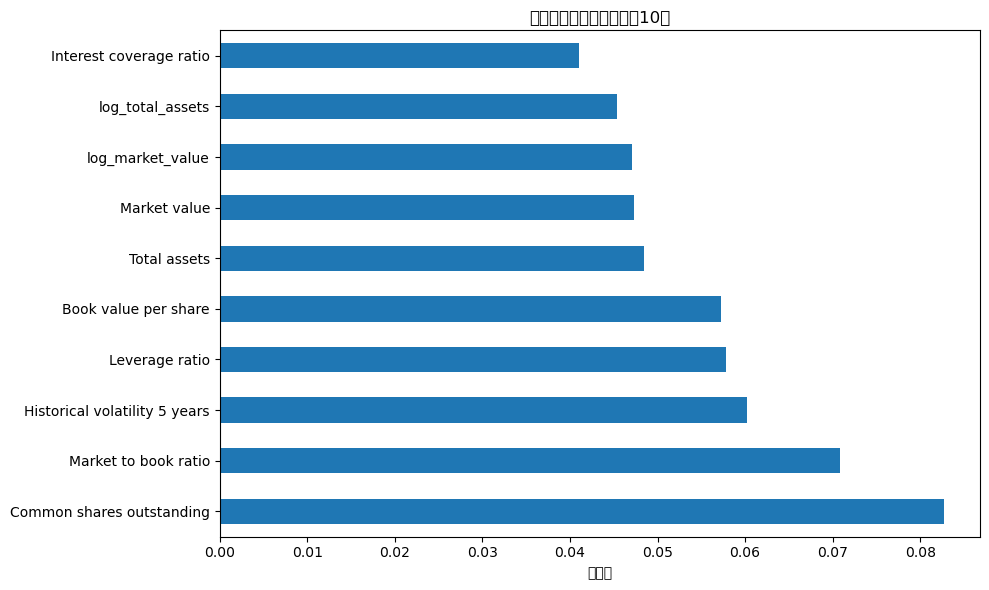

In [22]:
# 随机森林特征重要性图
rf_importance = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
rf_importance.head(10).plot(kind='barh')
plt.title('随机森林特征重要性（前10）')
plt.xlabel('重要性')
plt.tight_layout()
plt.savefig('vis/rf_feature_importance.png')
plt.show()

# 随机森林预测 vs 实际值散点图
y_pred_rf = rf.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('随机森林预测 vs 实际值')
plt.tight_layout()
plt.savefig('vis/rf_pred_vs_actual.png')
plt.show()

In [15]:
# XGBoost（超参数调优）
print("\n### XGBoost 模型 ###")
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10], 'learning_rate': [0.05, 0.1]}
xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
                        xgb_param_grid, cv=5, scoring='r2')
xgb_grid.fit(X_train, y_train)
print("最佳参数:", xgb_grid.best_params_)
xgb_model = xgb_grid.best_estimator_
xgb_r2 = xgb_model.score(X_test, y_test)
print(f"XGBoost R² (测试集): {xgb_r2:.4f}")


### XGBoost 模型 ###
最佳参数: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
XGBoost R² (测试集): 0.9026


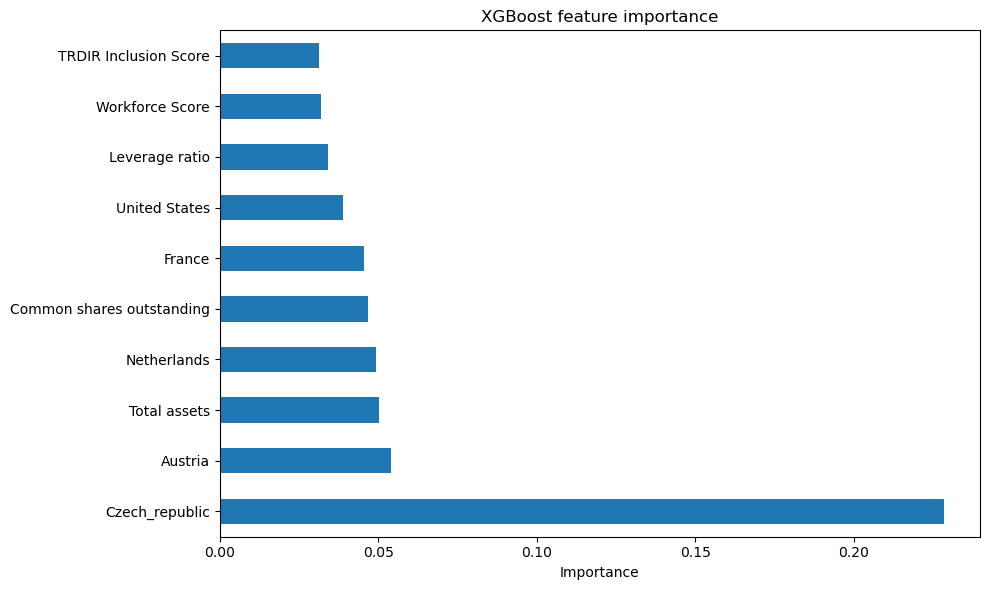

In [23]:
# XGBoost 特征重要性图
xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_importance.head(10).plot(kind='barh')
plt.title('XGBoost feature importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig("xgboost.png")   
plt.show()
 

C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\1586668498.py:9: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\1586668498.py:9: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\1586668498.py:9: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\1586668498.py:9: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\1586668498.py:9: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jiaju\AppData\Local\Temp\ipykernel_28956\1586668498.py:10: UserWarning: Glyph 23454 (\N{CJK

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jiaju\\vis\\xgb_pred_vs_actual.png'

C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 38469 (\N{CJK UNIFIED IDEOGRAPH-9645}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\jiaju\.anaconda\Lib\site-packages\IPython\core\pylabtools.py:

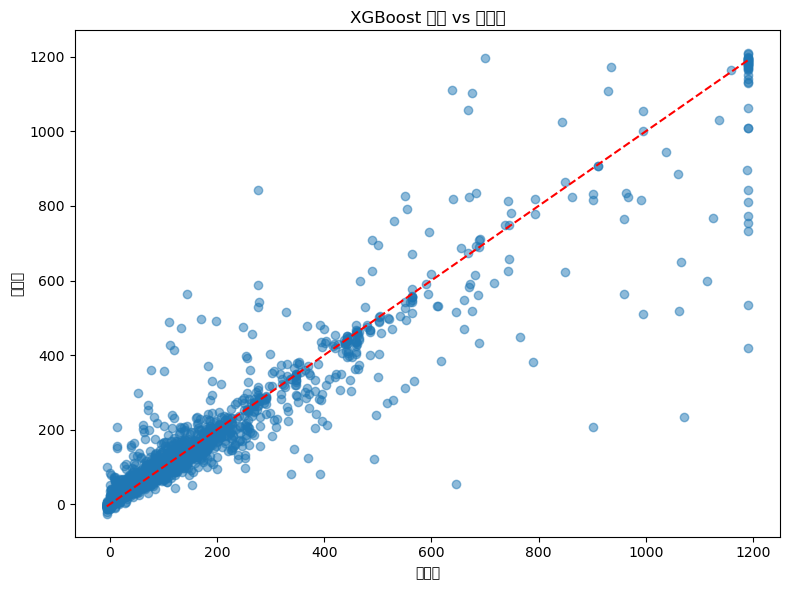

In [20]:
# XGBoost 预测 vs 实际值散点图
y_pred_xgb = xgb_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('XGBoost 预测 vs 实际值')
plt.tight_layout()
plt.savefig('vis/xgb_pred_vs_actual.png')
plt.show()


### SHAP values ###


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jiaju\\vis\\shap_summary.png'

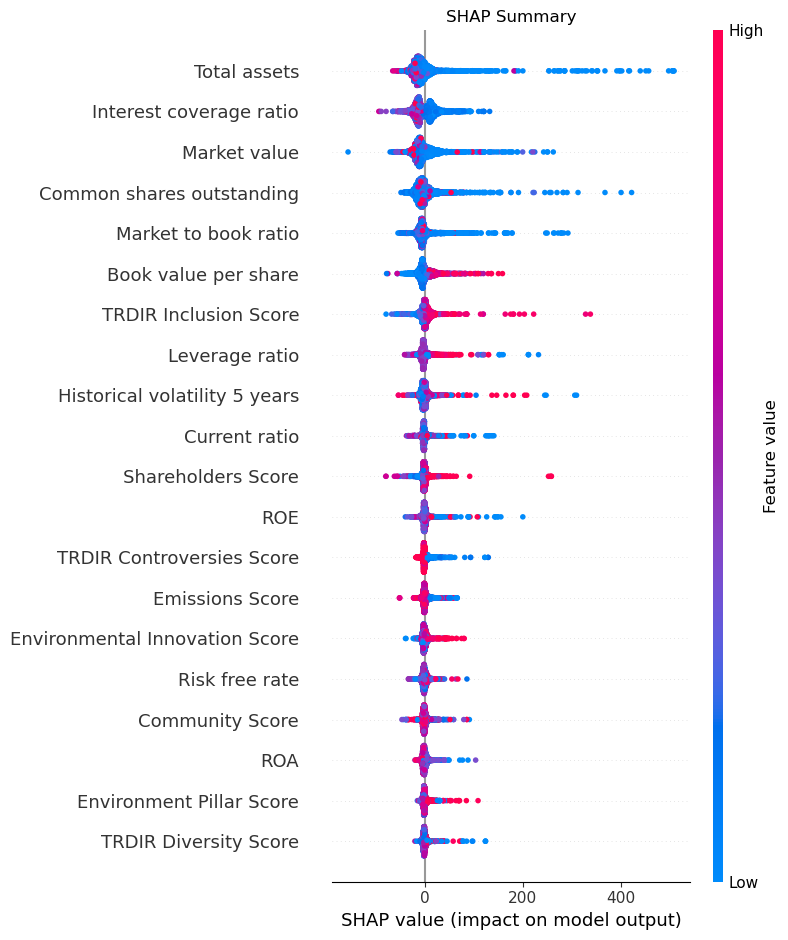

In [25]:
# 6. 解释性分析
# SHAP 值分析
print("\n### SHAP values ###")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.title("SHAP Summary")
plt.tight_layout()
plt.savefig('vis/shap_summary.png')
plt.show()

# PDP 图（以 ESG Controversies Score 为例）
print("\n### PDP ###")
plt.figure(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(xgb_model, X_test, features=['ESG Controversies Score'],
                                        feature_names=feature_names, grid_resolution=50)
plt.title("PDP - ESG Controversies Score")
plt.tight_layout()
plt.savefig('pdp_esg_controversies.png')
plt.show()



In [ ]:
from linearmodels.panel import PanelOLS
from statsmodels.iolib.summary2 import summary_col
import pandas as pd
import statsmodels.api as sm

# Ensure 'COMPANY' and 'Date' are in the index for panel structure
df = df.set_index(['COMPANY', 'Date'])

# List of control variables
controls = [
    'Current ratio', 'Interest coverage ratio', 'Historical volatility 5 years',
    'Market value', 'ROA', 'ROE', 'Total assets', 'Leverage ratio',
    'Market to book ratio', 'log_total_assets', 'log_market_value'
]

# List of ESG IVs
ivs = [
    'Environment Pillar Score',
    'Social Pillar Score',
    'Governance Pillar Score',
    'ESG Controversies Score'
]

# Prepare dependent variable
y = df['cds_spread_wins']

# Run FE models
fe_models = []
for iv in ivs:
    X = df[[iv] + controls].copy()
    X = sm.add_constant(X)
    model = PanelOLS(y, X, entity_effects=True, time_effects=True).fit(cov_type='clustered', cluster_entity=True)
    fe_models.append(model)

# Combine results using summary_col
results_table = summary_col(
    results=[m for m in fe_models],
    model_names=['Env Pillar', 'Social Pillar', 'Governance Pillar', 'ESG Controversy'],
    stars=True,
    float_format='%0.3f',
    info_dict={'R²': lambda x: f"{x.rsquared:.3f}", 'N': lambda x: f"{int(x.nobs)}"}
)

print(results_table)


In [32]:
# 7. 稳健性检验
# 行业分组分析
print("\n### 行业分组分析 ###")
industries = df['ICB industry name'].unique()
for industry in industries:
    data_industry = df[df['ICB industry name'] == industry]
    if len(data_industry) > 10:
        X_ind = scaler.transform(data_industry[feature_names])
        y_ind = data_industry['CDS spread']
        model_ind = LinearRegression()
        model_ind.fit(X_ind, y_ind)
        r2_ind = model_ind.score(X_ind, y_ind)
        print(f"行业 {industry} R²: {r2_ind:.4f}")

# 危机前后分析（使用随机森林模型）
print("\n### 危机前后分析 ###")
data_pre_crisis = df[df['Date'] < '2020-03-11']
X_pre = scaler.transform(data_pre_crisis[feature_names])
y_pre = data_pre_crisis['CDS spread']
rf_pre = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_pre.fit(X_pre, y_pre)
print(f"危机前随机森林 R²: {rf_pre.score(X_pre, y_pre):.4f}")

data_post_crisis = df[df['Date'] >= '2020-03-11']
X_post = scaler.transform(data_post_crisis[feature_names])
y_post = data_post_crisis['CDS spread']
rf_post = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_post.fit(X_post, y_post)
print(f"危机后随机森林 R²: {rf_post.score(X_post, y_post):.4f}")



### 行业分组分析 ###
行业 Industrials R²: 0.3323
行业 Health Care R²: 0.5534
行业 Consumer Discretionary R²: 0.2826
行业 Basic Materials R²: 0.5610
行业 Consumer Staples R²: 0.6440
行业 Utilities R²: 0.2970
行业 Real Estate R²: 0.3340
行业 Technology R²: 0.5001
行业 Telecommunications R²: 0.5902
行业 Energy R²: 0.5846

### 危机前后分析 ###
危机前随机森林 R²: 0.9720
危机后随机森林 R²: 0.9857


In [ ]:
# ESG 波动性分析
print("\n### ESG 波动性分析 ###")
esg_columns = [col for col in feature_names if 'Score' in col]
data['ESG_Volatility'] = data[esg_columns].std(axis=1)
features_with_vol = pd.concat([features, data['ESG_Volatility']], axis=1)
scaler_with_vol = StandardScaler()
features_scaled_with_vol = scaler_with_vol.fit_transform(features_with_vol)
X_train_with_vol, X_test_with_vol, y_train, y_test = train_test_split(features_scaled_with_vol, target, test_size=0.2, random_state=42)
rf_with_vol = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_with_vol.fit(X_train_with_vol, y_train)
rf_r2_with_vol = rf_with_vol.score(X_test_with_vol, y_test)
print(f"加入 ESG 波动性后的随机森林 R² (测试集): {rf_r2_with_vol:.4f}")

# 识别影响最大的 ESG 子评分
print("\n### 识别影响最大的 ESG 子评分 ###")
esg_sub_scores = [col for col in feature_names if 'Score' in col]
shap_esg = pd.DataFrame(shap_values, columns=feature_names)[esg_sub_scores].abs().mean().sort_values(ascending=False)
print("SHAP 值分析：影响最大的 ESG 子评分（前5个）：")
print(shap_esg.head(5))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap
from linearmodels.panel import PanelOLS, RandomEffects
from sklearn.inspection import PartialDependenceDisplay
import os
import warnings
from scipy import stats
from statsmodels.regression.quantile_regression import QuantReg

warnings.filterwarnings('ignore')

# 设置 matplotlib 支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 创建 vis 文件夹用于保存可视化结果
if not os.path.exists('vis'):
    os.makedirs('vis')

# 1. 数据加载和预处理
print("### 数据加载和预处理 ###")
data = pd.read_excel('Final_data.xlsx')

# 将 Date 列转换为日期格式
def parse_quarter(date_str):
    quarter, year = date_str.split()
    year = int(year)
    if quarter == 'Q1':
        return f'{year}-01-01'
    elif quarter == 'Q2':
        return f'{year}-04-01'
    elif quarter == 'Q3':
        return f'{year}-07-01'
    elif quarter == 'Q4':
        return f'{year}-10-01'
    return None

data['Date'] = pd.to_datetime(data['Date'].apply(parse_quarter), errors='coerce')
print("Date 列类型：", data['Date'].dtype)
print("Date 列前五行：\n", data['Date'].head())

# 处理缺失值
data = data.fillna(method='ffill').fillna(method='bfill')

# 选择特征和目标变量
exclude_cols = ['CDS_spread', 'ID', 'Date', 'Quarter', 'Year', 'Company', 'Country',
                'ISIN CODE', 'TICKER SYMBOL', 'ICB industry name', 'ICB sector name']
features = data.drop(columns=exclude_cols)
target = data['CDS_spread']

# 移除国家虚拟变量和行业虚拟变量
country_dummies = [col for col in features.columns if col in ['AUSTRIA', 'BELGIUM', 'CZECH_REPUBLIC', 'DENMARK',
                                                             'FINLAND', 'FRANCE', 'GERMANY', 'GREECE', 'ITALY',
                                                             'NETHERLANDS', 'NORWAY', 'PORTUGAL', 'SPAIN', 'SWEDEN',
                                                             'SWITZERLAND', 'UNITED_KINGDOM', 'UNITED_STATES']]
industry_dummies = [col for col in features.columns if col in ['Basic_Materials', 'Consumer_Discretionary',
                                                               'Consumer_Staples', 'Energy', 'Financials',
                                                               'Health_Care', 'Industrials', 'Real_Estate',
                                                               'Technology', 'Telecommunications', 'Utilities']]
features = features.drop(columns=country_dummies + industry_dummies)
print(f"调试信息：国家虚拟变量: {country_dummies}")
print(f"调试信息：行业虚拟变量: {industry_dummies}")
print(f"调试信息：保留的特征: {features.columns.tolist()}")

# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
feature_names = features.columns

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

# 2. 描述性统计
print("\n### 描述性统计 ###")
print("基本统计信息：")
print(data.describe())

# 相关性分析
correlation = data[feature_names.tolist() + ['CDS_spread']].corr()
print("与 CDS_spread 的相关性（前10个）：")
print(correlation['CDS_spread'].sort_values(ascending=False).head(10))

# 离群值检测
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3)
print("离群值数量：", len(outliers[0]))

# ESG 评分的非线性转换（对数转换）
esg_log = np.log1p(data['ESG Score'])
print("ESG Score 对数转换后描述：")
print(esg_log.describe())

# 3. 面板回归分析
print("\n### 面板回归分析 ###")
data_panel = data.set_index(['Company', 'Date'])

# 固定效应模型
panel_model_fe = PanelOLS(data_panel['CDS_spread'], data_panel[feature_names], entity_effects=True, time_effects=True, drop_absorbed=True)
panel_results_fe = panel_model_fe.fit()
print("固定效应面板回归结果：")
print(panel_results_fe.summary)

# 随机效应模型
panel_model_re = RandomEffects(data_panel['CDS_spread'], data_panel[feature_names])
panel_results_re = panel_model_re.fit()
print("随机效应面板回归结果：")
print(panel_results_re.summary)

# 分位数回归
quantiles = [0.1, 0.5, 0.9]
for q in quantiles:
    model = QuantReg(data['CDS_spread'], data[feature_names])
    res = model.fit(q=q)
    print(f"分位数 {q} 回归结果：")
    print(res.summary())

# 4. LASSO 回归（优化 alpha）
print("\n### LASSO 回归分析 ###")
lasso_cv = LassoCV(alphas=np.logspace(-6, 1, 200), cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)
print(f"最佳 alpha: {lasso_cv.alpha_}")
lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso.fit(X_train, y_train)
print("LASSO 回归 R² (测试集):", lasso.score(X_test, y_test))
lasso_coef = pd.Series(lasso.coef_, index=feature_names)
print("LASSO 系数：")
print(lasso_coef[lasso_coef != 0].sort_values(ascending=False))

# LASSO 系数图
plt.figure(figsize=(10, 6))
lasso_coef[lasso_coef != 0].sort_values().plot(kind='barh')
plt.title('LASSO 回归系数')
plt.xlabel('系数值')
plt.tight_layout()
plt.savefig('vis/lasso_coefficients.png')
plt.show()

# 5. 机器学习模型
# 随机森林（超参数调优）
print("\n### 随机森林模型 ###")
rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), rf_param_grid, cv=5, scoring='r2')
rf_grid.fit(X_train, y_train)
print("最佳参数:", rf_grid.best_params_)
rf = rf_grid.best_estimator_
rf_r2 = rf.score(X_test, y_test)
print(f"随机森林 R² (测试集): {rf_r2:.4f}")

# 随机森林特征重要性图
rf_importance = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
rf_importance.head(10).plot(kind='barh')
plt.title('随机森林特征重要性（前10）')
plt.xlabel('重要性')
plt.tight_layout()
plt.savefig('vis/rf_feature_importance.png')
plt.show()

# 随机森林预测 vs 实际值散点图
y_pred_rf = rf.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('随机森林预测 vs 实际值')
plt.tight_layout()
plt.savefig('vis/rf_pred_vs_actual.png')
plt.show()

# XGBoost（超参数调优）
print("\n### XGBoost 模型 ###")
xgb_param_grid = {'n_estimators': [100, 200], 'max_depth': [5, 10], 'learning_rate': [0.05, 0.1]}
xgb_grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
                        xgb_param_grid, cv=5, scoring='r2')
xgb_grid.fit(X_train, y_train)
print("最佳参数:", xgb_grid.best_params_)
xgb_model = xgb_grid.best_estimator_
xgb_r2 = xgb_model.score(X_test, y_test)
print(f"XGBoost R² (测试集): {xgb_r2:.4f}")

# XGBoost 特征重要性图
xgb_importance = pd.Series(xgb_model.feature_importances_, index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_importance.head(10).plot(kind='barh')
plt.title('XGBoost 特征重要性（前10）')
plt.xlabel('重要性')
plt.tight_layout()
plt.savefig('vis/xgb_feature_importance.png')
plt.show()

# XGBoost 预测 vs 实际值散点图
y_pred_xgb = xgb_model.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('XGBoost 预测 vs 实际值')
plt.tight_layout()
plt.savefig('vis/xgb_pred_vs_actual.png')
plt.show()

# 6. 解释性分析
# SHAP 值分析
print("\n### SHAP 值分析 ###")
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
plt.title("SHAP 值总结图")
plt.tight_layout()
plt.savefig('vis/shap_summary.png')
plt.show()

# PDP 图（以 ESG Controversies Score 为例）
print("\n### PDP 图分析 ###")
plt.figure(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(xgb_model, X_test, features=['ESG Controversies Score'],
                                        feature_names=feature_names, grid_resolution=50)
plt.title("PDP 图 - ESG Controversies Score")
plt.tight_layout()
plt.savefig('vis/pdp_esg_controversies.png')
plt.show()

# 7. 稳健性检验
# 行业分组分析
print("\n### 行业分组分析 ###")
industries = data['ICB industry name'].unique()
for industry in industries:
    data_industry = data[data['ICB industry name'] == industry]
    if len(data_industry) > 10:
        X_ind = scaler.transform(data_industry[feature_names])
        y_ind = data_industry['CDS_spread']
        model_ind = LinearRegression()
        model_ind.fit(X_ind, y_ind)
        r2_ind = model_ind.score(X_ind, y_ind)
        print(f"行业 {industry} R²: {r2_ind:.4f}")

# 危机前后分析（使用随机森林模型）
print("\n### 危机前后分析 ###")
data_pre_crisis = data[data['Date'] < '2019-01-01']
X_pre = scaler.transform(data_pre_crisis[feature_names])
y_pre = data_pre_crisis['CDS_spread']
rf_pre = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_pre.fit(X_pre, y_pre)
print(f"危机前随机森林 R²: {rf_pre.score(X_pre, y_pre):.4f}")

data_post_crisis = data[data['Date'] >= '2019-01-01']
X_post = scaler.transform(data_post_crisis[feature_names])
y_post = data_post_crisis['CDS_spread']
rf_post = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_post.fit(X_post, y_post)
print(f"危机后随机森林 R²: {rf_post.score(X_post, y_post):.4f}")

# ESG 波动性分析
print("\n### ESG 波动性分析 ###")
esg_columns = [col for col in feature_names if 'Score' in col]
data['ESG_Volatility'] = data[esg_columns].std(axis=1)
features_with_vol = pd.concat([features, data['ESG_Volatility']], axis=1)
scaler_with_vol = StandardScaler()
features_scaled_with_vol = scaler_with_vol.fit_transform(features_with_vol)
X_train_with_vol, X_test_with_vol, y_train, y_test = train_test_split(features_scaled_with_vol, target, test_size=0.2, random_state=42)
rf_with_vol = RandomForestRegressor(**rf_grid.best_params_, random_state=42, n_jobs=-1)
rf_with_vol.fit(X_train_with_vol, y_train)
rf_r2_with_vol = rf_with_vol.score(X_test_with_vol, y_test)
print(f"加入 ESG 波动性后的随机森林 R² (测试集): {rf_r2_with_vol:.4f}")

# 识别影响最大的 ESG 子评分
print("\n### 识别影响最大的 ESG 子评分 ###")
esg_sub_scores = [col for col in feature_names if 'Score' in col]
shap_esg = pd.DataFrame(shap_values, columns=feature_names)[esg_sub_scores].abs().mean().sort_values(ascending=False)
print("SHAP 值分析：影响最大的 ESG 子评分（前5个）：")
print(shap_esg.head(5))